In [10]:
# install
!pip install findspark
!pip install pyspark
import findspark
findspark.init()

In [11]:
# init
import findspark
findspark.init()

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Start Spark session
spark = SparkSession.builder.appName("Amazon Fine Food Reviews Classification").getOrCreate()

# Load dataset
df = spark.read.csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv', header=True, inferSchema=True)

# Drop rows with missing values
df = df.dropna()


In [12]:
# Create a new label column: convert rating to binary classification (positive or negative)
df = df.withColumn("label", (df.Score > 3).cast("integer"))  # Label as 1 for positive and 0 for negative

df = df.filter(df['label'].isNotNull())
df = df.filter((df['label'] == 0) | (df['label'] == 1))


In [13]:
# Split the data into train and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

# Tokenize the reviews
tokenizer = Tokenizer(inputCol="Text", outputCol="words")

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# Convert words to term frequency
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)

# Apply IDF (inverse document frequency)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Initialize RandomForest classifier
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label", numTrees=50)

# Build pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, scaler, rf])

# Fit the model on the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")



24/10/21 10:01:32 WARN MemoryStore: Not enough space to cache rdd_170_3 in memory! (computed 16.1 MiB so far)
24/10/21 10:01:32 WARN BlockManager: Persisting block rdd_170_3 to disk instead.
24/10/21 10:01:32 WARN MemoryStore: Not enough space to cache rdd_170_1 in memory! (computed 16.1 MiB so far)
24/10/21 10:01:32 WARN BlockManager: Persisting block rdd_170_1 to disk instead.
24/10/21 10:01:32 WARN MemoryStore: Not enough space to cache rdd_170_0 in memory! (computed 36.5 MiB so far)
24/10/21 10:01:32 WARN BlockManager: Persisting block rdd_170_0 to disk instead.
24/10/21 10:01:32 WARN MemoryStore: Not enough space to cache rdd_170_2 in memory! (computed 36.5 MiB so far)
24/10/21 10:01:32 WARN BlockManager: Persisting block rdd_170_2 to disk instead.
24/10/21 10:02:46 WARN MemoryStore: Not enough space to cache rdd_170_3 in memory! (computed 130.0 MiB so far)
24/10/21 10:02:49 WARN MemoryStore: Not enough space to cache rdd_170_1 in memory! (computed 130.0 MiB so far)
24/10/21 10:02

Test Accuracy: 0.7781556099241294


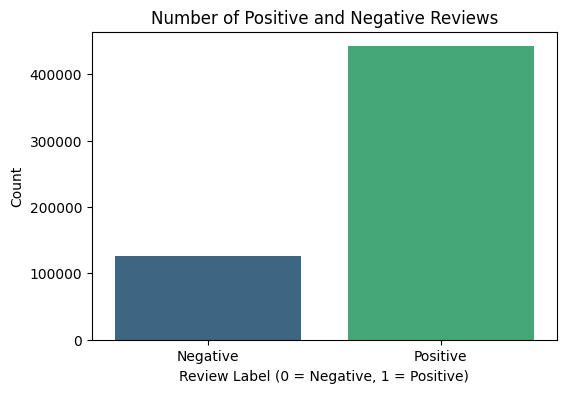

In [14]:
# Convert the Spark DataFrame to a Pandas DataFrame for easier plotting
df_pandas = df.select('label').toPandas()

# Count the number of positive and negative reviews
review_counts = df_pandas['label'].value_counts()

# Plot the data
plt.figure(figsize=(6,4))
sns.barplot(x=review_counts.index, y=review_counts.values, palette="viridis")
plt.title('Number of Positive and Negative Reviews')
plt.xlabel('Review Label (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()